In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.stats import zscore

In [48]:
# 2. Data Loading and Initial Exploration
df = pd.read_csv('breast_cancer_wisconsin.csv')
df.head()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [44]:
# 3. Data Preprocessing

#df.drop('Sample_code_number', axis=1, inplace=True)
median_value = df['Bare_Nuclei'].median()
df['Bare_Nuclei'] = df['Bare_Nuclei'].fillna(median_value)

df['Bare_Nuclei'] = df['Bare_Nuclei'].astype(int)

df['Class'] = df['Class'].map({2:'Benign', 4:'Malignant'})

print("--- Data Preprocessing Results ---")
print(df.info())

--- Data Preprocessing Results ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Clump_Thickness              699 non-null    int64 
 1   Uniformity_of_Cell_Size      699 non-null    int64 
 2   Uniformity_of_Cell_Shape     699 non-null    int64 
 3   Marginal_Adhesion            699 non-null    int64 
 4   Single_Epithelial_Cell_Size  699 non-null    int64 
 5   Bare_Nuclei                  699 non-null    int64 
 6   Bland_Chromatin              699 non-null    int64 
 7   Normal_Nucleoli              699 non-null    int64 
 8   Mitoses                      699 non-null    int64 
 9   Class                        0 non-null      object
dtypes: int64(9), object(1)
memory usage: 54.7+ KB
None


In [31]:
# 4. Outlier Analysis and Handling (using Capping)
df_capped = df.copy()
numeric_features = df_capped.select_dtypes(include=np.number)

for col in numeric_features.columns:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after capping: {df_capped.shape} (No rows were removed!)")

Original DataFrame shape: (699, 10)
DataFrame shape after capping: (699, 10) (No rows were removed!)


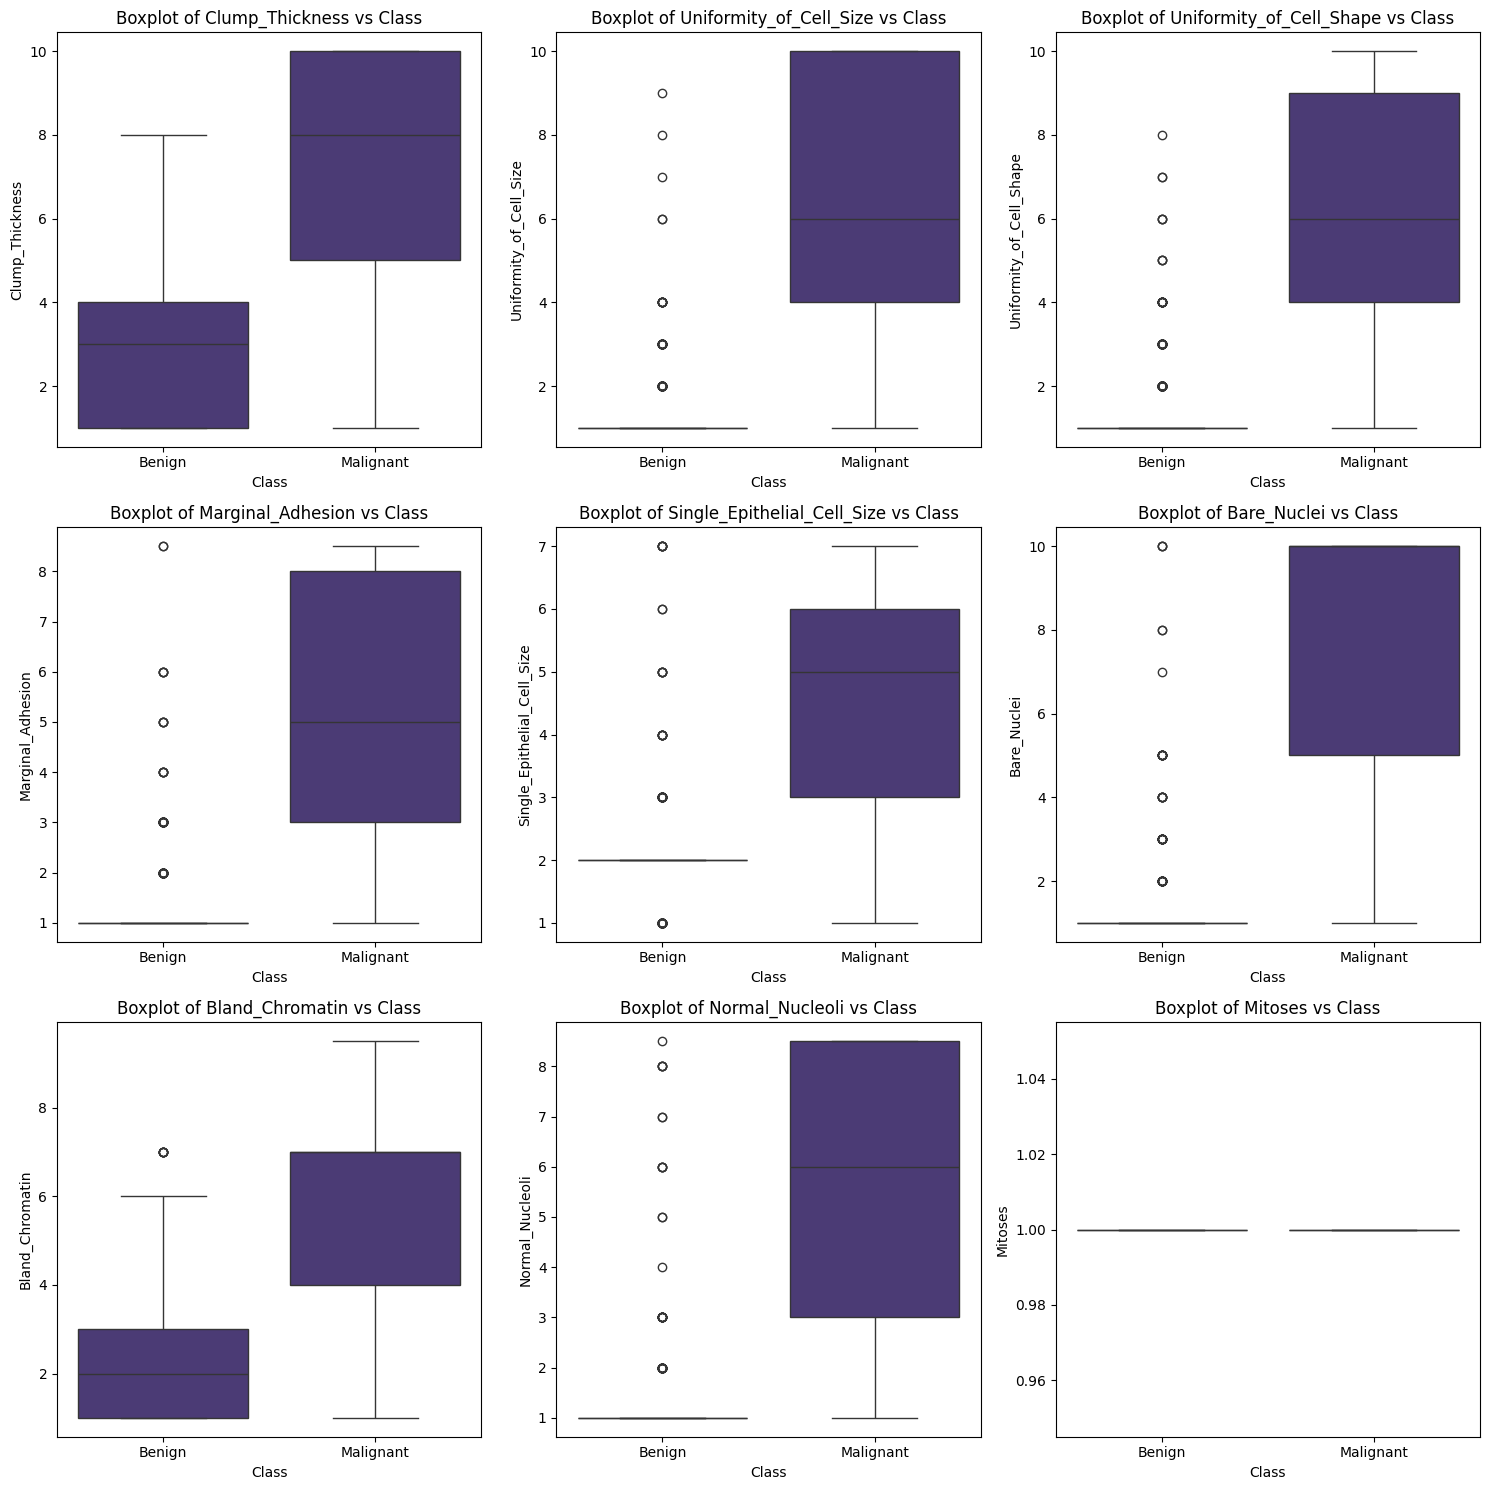

In [32]:
# 5. Exploratory Data Analysis (EDA) on Cleaned Data
sns.set_palette('viridis')
features = df_capped.columns[:-1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x='Class', y=col, data=df_capped, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} vs Class')

plt.tight_layout()
plt.show()

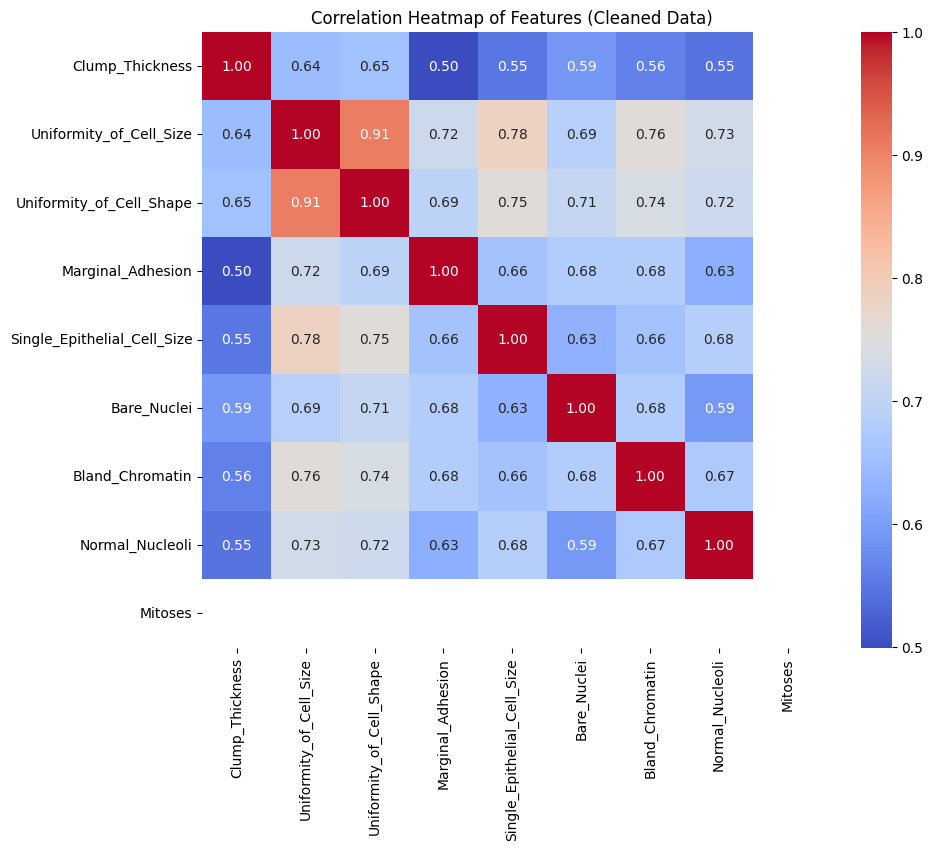

In [33]:
# Correlation heatmap to check for multicollinearity
plt.figure(figsize=(10, 8))

numeric_df_for_corr = df_capped.select_dtypes(include=np.number)
cor_matrix = numeric_df_for_corr.corr()
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features (Cleaned Data)")
plt.show()

In [45]:
# 6. Model Training
X = df_capped.drop('Class', axis=1)
Y = df_capped['Class']

# Manual feature selection based on EDA insights
selected_features = ['Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Bare_Nuclei', 'Clump_Thickness']
X_selected = X[selected_features]

#Splitting
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.2, random_state=42,stratify=Y)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")
print(f"Class distribution in Test set:\n{Y_test.value_counts()}")

Training set size: 559 rows
Test set size: 140 rows
Class distribution in Test set:
Class
Benign       92
Malignant    48
Name: count, dtype: int64


In [46]:
# 7. Modeling and Prediction
model = GaussianNB()
model.fit(X_train, Y_train)
#Prediction
y_pred = model.predict(X_test)

In [47]:
# 8. Model Evaluation
print("--- Model Evaluation Results ---")
print(f"Accuracy Score: {accuracy_score(Y_test, y_pred):.4f}\n")
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

--- Model Evaluation Results ---
Accuracy Score: 0.9571

Confusion Matrix:
[[89  3]
 [ 3 45]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97        92
   Malignant       0.94      0.94      0.94        48

    accuracy                           0.96       140
   macro avg       0.95      0.95      0.95       140
weighted avg       0.96      0.96      0.96       140

